# Import libraries

In [39]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import pickle

import warnings
warnings.filterwarnings("ignore")

# Train-Test
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Regression models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Load data from pickle file

In [40]:

df_train_processed = pd.read_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

In [41]:
df_train_processed = df_train_processed[df_train_processed['RainTomorrow'].notna()]

# Split into train/cv
X_train, X_cv, y_train, y_cv = train_test_split(
    df_train_processed.drop(['RainTomorrow','RainfallTomorrow'], axis=1),
    df_train_processed['RainfallTomorrow'],
    test_size=0.1,
    random_state=0)

In [4]:
def print_results(y_pred,y_true):
    print("MSE = "+"{:10.2f}".format(mean_squared_error(y_pred, y_true, squared=True)))
    print("RMSE = "+"{:10.2f}".format(mean_squared_error(y_pred, y_true, squared=False)))

## Feature selection: PCA

In [45]:
explained_variance = .95
pca = PCA(n_components=explained_variance).fit(X_train)

X_train_pca = pca.transform(X_train)
X_cv_pca = pca.transform(X_cv)

# pca = PCA(n_components=explained_variance).fit(df_train_processed)
# df_train_pca = pca.transform(df_train_processed)

print("Number of components required to explain "+str(explained_variance)+"% of the variance = "+str(X_train_pca.shape[1]))

Number of components required to explain 0.95% of the variance = 15


## Feature selection: RFE (with simple Logistic Regression)

In [46]:
logisticRegr = LinearRegression()

rfe = RFE(estimator=logisticRegr, step=1, verbose=0, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train.values.ravel())

total_cols = np.array(X_train.columns.values.tolist())
selected_cols = total_cols[rfe.support_].tolist()
X_train_rfe = X_train[selected_cols]
X_cv_rfe =  X_cv[selected_cols]
print("Columns selected: "+str(selected_cols))

Columns selected: ['Rainfall', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm', 'RainToday', 'LocationType_1', 'LocationType_2', 'LocationType_3', 'LocationType_4', 'PressureMean', 'TempMean', 'imputed_mean', 'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_sin']


In [47]:
# Save data
open_file = open('./data/reg_pca.pkl', "wb")
pickle.dump(pca, open_file)
open_file.close()

open_file = open('./data/reg_rfe_cols.pkl', "wb")
pickle.dump(selected_cols, open_file)
open_file.close()

# Train Models

In [7]:
def train_models(X_train_ ,y_train_ ,X_cv_ ,y_cv_,features_selection='',degrees=[2,3,4]):

    model_list=[]

    # DummyRegressor
    reg = DummyRegressor(strategy="mean")
    reg.fit(X_train_, y_train_)
    y_pred = reg.predict(X_cv_)

    model_list.append(
        {'name': 'DummyRegressor',
        'features_selection': features_selection,
        'score':  reg.score(X_cv_, y_cv_),
        'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
        'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
        'r2_score': r2_score(y_pred,y_cv_),
        'poly_reg': None,
        'model': reg
        }
    )

    reg_list=[]
    reg_list_names=[]

    # LinearRegression
    reg = LinearRegression()
    
    reg_list.append(reg)
    reg_list_names.append('LinearRegression')

    reg.fit(X_train_, y_train_)
    y_pred = reg.predict(X_cv_)

    model_list.append(
        {'name': 'LinearRegression',
        'features_selection': features_selection,
        'score': reg.score(X_cv_, y_cv_),
        'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
        'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
        'r2_score': r2_score(y_pred,y_cv_),
        'poly_reg': None,
        'model': reg
        }
    )

    # Ridge
    reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=10)

    reg_list.append(reg)
    reg_list_names.append('Ridge')

    reg.fit(X_train_, y_train_)
    y_pred = reg.predict(X_cv_)

    model_list.append(
        {'name': 'Ridge_l2',
        'features_selection': features_selection,
        'score': reg.score(X_cv_, y_cv_),
        'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
        'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
        'r2_score': r2_score(y_pred,y_cv_),
        'poly_reg': None,
        'model': reg
        }
    )

    # Lasso
    reg = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1,2], cv=10)

    reg_list.append(reg)
    reg_list_names.append('Lasso')

    reg.fit(X_train_, y_train_)
    y_pred = reg.predict(X_cv_)

    model_list.append(
        {'name': 'Lasso_l1',
        'features_selection': features_selection,
        'score': reg.score(X_cv_, y_cv_),
        'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
        'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
        'r2_score': r2_score(y_pred,y_cv_),
        'poly_reg': None,
        'model': reg
        }
    )

    # ElasticNet
    reg = ElasticNetCV(alphas=[1e-3, 1e-2, 1e-1, 1], 
                        l1_ratio= [.1, .5, .7, .9, .95, .99, 1], cv=10)

    reg_list.append(reg)
    reg_list_names.append('ElasticNet')

    reg.fit(X_train_, y_train_)
    y_pred = reg.predict(X_cv_)

    model_list.append(
        {'name': 'ElasticNet',
        'features_selection': features_selection,
        'score': reg.score(X_cv_, y_cv_),
        'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
        'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
        'r2_score': r2_score(y_pred,y_cv_),
        'poly_reg': None,
        'model': reg
        }
    )
        

    # PolynomialFeatures + Reg
    for d in degrees:
        if d<4:
            poly_reg = PolynomialFeatures(degree=d,interaction_only=True)
            X_poly = poly_reg.fit_transform(X_train_)
            
            for pol_reg,reg_name in zip(reg_list,reg_list_names):
                print("running ploly d="+str(d)+" + Reg = "+reg_name)
                pol_reg.fit(X_poly, y_train_)

                y_pred = pol_reg.predict(poly_reg.transform(X_cv_))
                model_list.append(
                    {'name': 'PolynomialFeatures_'+str(d)+"_reg-"+reg_name,
                    'features_selection': features_selection,
                    'score': pol_reg.score(poly_reg.transform(X_cv_), y_cv_),
                    'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
                    'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
                    'r2_score': r2_score(y_pred,y_cv_),
                    'poly_reg': poly_reg,
                    'model': reg
                }
        )
        else:
            print("running ploly d="+str(d))
            poly_reg = PolynomialFeatures(degree=d,interaction_only=True)
            X_poly = poly_reg.fit_transform(X_train_)

            pol_reg = LinearRegression()
            pol_reg.fit(X_poly, y_train_)

            y_pred = pol_reg.predict(poly_reg.transform(X_cv_))
            model_list.append(
                {'name': 'PolynomialFeatures_'+str(d),
                'features_selection': features_selection,
                'score': pol_reg.score(poly_reg.transform(X_cv_), y_cv_),
                'MSE': mean_squared_error(y_pred, y_cv_, squared=True),
                'RMSE': mean_squared_error(y_pred, y_cv_, squared=False),
                'r2_score': r2_score(y_pred,y_cv_),
                'poly_reg': poly_reg,
                'model': reg
            }
        )

    return model_list

In [8]:
model_list=[]
        
model_list_pca = train_models(X_train_pca, y_train, X_cv_pca, y_cv, features_selection='PCA')
model_list_rfe = train_models(X_train_rfe, y_train, X_cv_rfe, y_cv, features_selection='RFE')

model_list = model_list_pca+model_list_rfe

running ploly d=2 + Reg = LinearRegression
running ploly d=2 + Reg = Ridge
running ploly d=2 + Reg = Lasso
running ploly d=2 + Reg = ElasticNet
running ploly d=3 + Reg = LinearRegression
running ploly d=3 + Reg = Ridge
running ploly d=3 + Reg = Lasso
running ploly d=3 + Reg = ElasticNet
running ploly d=4
running ploly d=2 + Reg = LinearRegression
running ploly d=2 + Reg = Ridge
running ploly d=2 + Reg = Lasso
running ploly d=2 + Reg = ElasticNet
running ploly d=3 + Reg = LinearRegression
running ploly d=3 + Reg = Ridge
running ploly d=3 + Reg = Lasso
running ploly d=3 + Reg = ElasticNet
running ploly d=4


In [42]:
models_df = None
column_names = ["name","features_selection","RMSE","MSE","score","r2_score","model"]
models_df = pd.DataFrame(columns=column_names)
for m in model_list:
    m_append = []
    for col in column_names:
        m_append.append(m[col])
    m_series = pd.Series(m_append, index = models_df.columns)
    models_df = models_df.append(m_series, ignore_index=True)
models_df[["name","features_selection","RMSE","score","r2_score"]]

,name,features_selection,RMSE,score,r2_score
0,DummyRegressor,PCA,1.001423e+00,-2.416110e-05,-8.531285e+37
1,LinearRegression,PCA,8.988121e-01,1.944113e-01,-2.969508e+00
2,Ridge_l2,PCA,8.988121e-01,1.944114e-01,-2.969576e+00
3,Lasso_l1,PCA,8.987677e-01,1.944909e-01,-3.023082e+00
4,ElasticNet,PCA,8.988004e-01,1.944324e-01,-2.981002e+00
5,PolynomialFeatures_2_reg-LinearRegression,PCA,8.713820e-01,2.428313e-01,-2.081872e+00
6,PolynomialFeatures_2_reg-Ridge,PCA,8.713819e-01,2.428314e-01,-2.081926e+00
7,PolynomialFeatures_2_reg-Lasso,PCA,8.712659e-01,2.430329e-01,-2.159474e+00
8,PolynomialFeatures_2_reg-ElasticNet,PCA,8.712865e-01,2.429972e-01,-2.123883e+00
9,PolynomialFeatures_3_reg-LinearRegression,PCA,8.590725e-01,2.640724e-01,-1.615320e+00


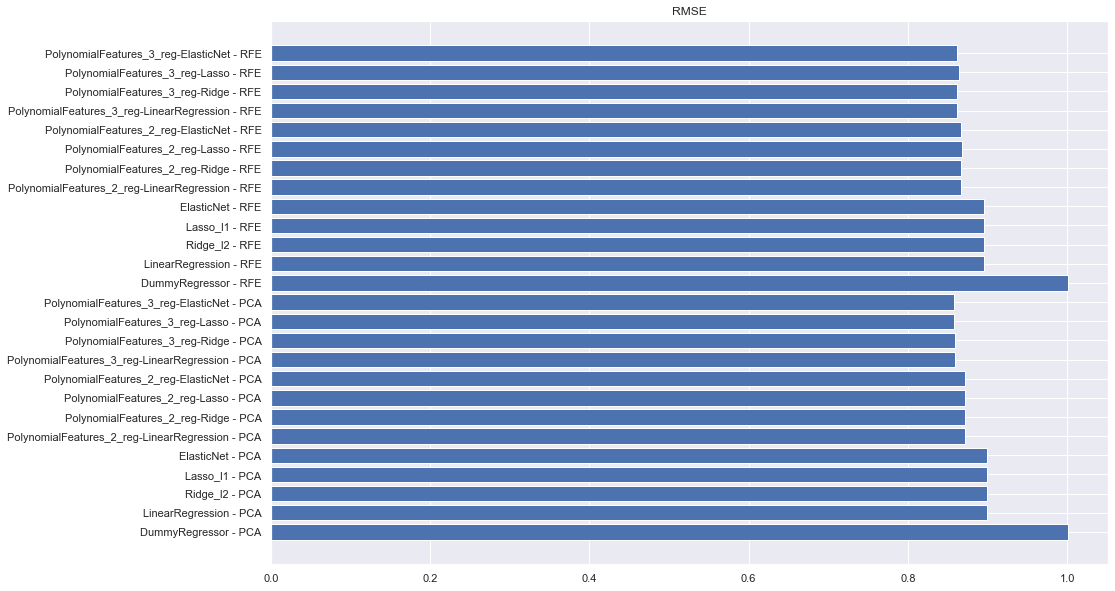

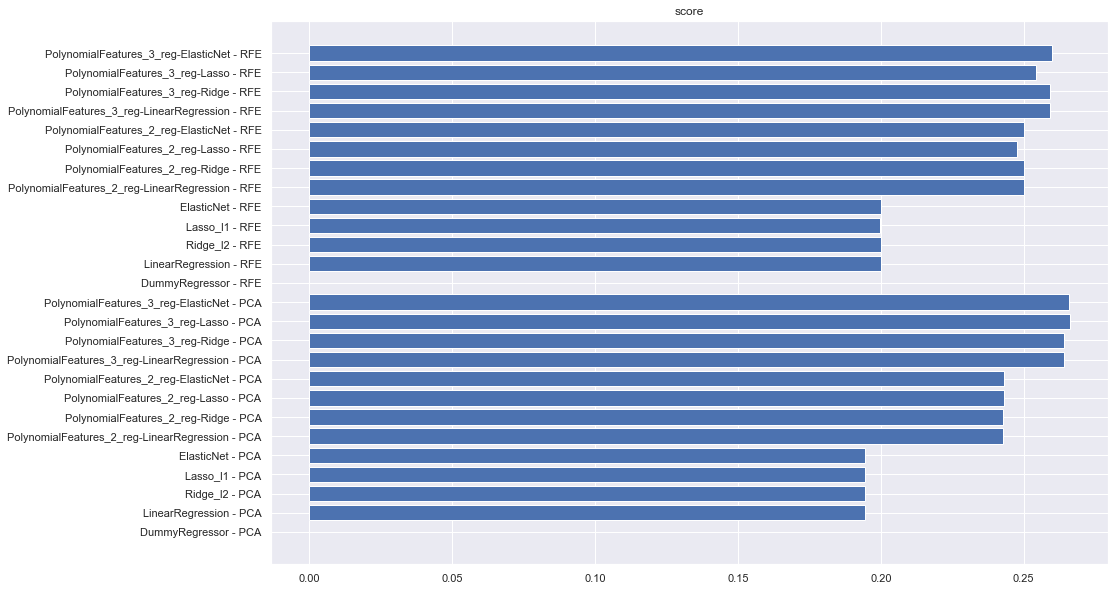

In [41]:
name = np.array(models_df.drop(models_df[models_df['name']=='PolynomialFeatures_4'].index)['name'],dtype='str')
features_selection = np.array(models_df.drop(models_df[models_df['name']=='PolynomialFeatures_4'].index)['features_selection'],dtype='str')
y=np.char.add(name," - ")
y=np.char.add(y,features_selection)
x_rmse = np.array(models_df.drop(models_df[models_df['name']=='PolynomialFeatures_4'].index)['RMSE'])
x_score = np.array(models_df.drop(models_df[models_df['name']=='PolynomialFeatures_4'].index)['score'])

fig = plt.figure(figsize=(15,10))
plt.barh(y,x_rmse)
plt.title('RMSE')
plt.show()

fig = plt.figure(figsize=(15,10))
plt.barh(y,x_score)
plt.title('score')
plt.show()

In [11]:
for m in model_list:
        if m['name']=='Ridge_l2' or m['name']=='Lasso_l1' or m['name']=='ElasticNet':
            if m['name']=='ElasticNet':
                print(str(m['name'])+" ("+str(m['features_selection'])+"): alpha = "+str(m['model'].alpha_)+" | l1_ratio = "+str(m['model'].l1_ratio_))
            else:
                print(str(m['name']+" ("+str(m['features_selection'])+"): alpha = "+str(m['model'].alpha_)))

Ridge_l2 (PCA): alpha = 1.0
Lasso_l1 (PCA): alpha = 0.001
ElasticNet (PCA): alpha = 0.001 | l1_ratio = 0.5
Ridge_l2 (RFE): alpha = 1.0
Lasso_l1 (RFE): alpha = 0.001
ElasticNet (RFE): alpha = 0.001 | l1_ratio = 0.1


In [22]:
# Save
open_file = open('./data/reg_list.pkl', "wb")
pickle.dump(model_list, open_file)
open_file.close()

models_df.to_pickle('./data/reg_df.pkl')


# # # Load
# open_file = open('./data/reg_list.pkl', "rb")
# model_list = pickle.load(open_file)
# open_file.close()

# models_df = pd.read_pickle('./data/reg_df.pkl')

In [14]:
metrics_list=["RMSE"]
for met in metrics_list:
    idx = models_df[met].argmin()
    name = models_df.iloc[idx]["name"] 
    features_selection = models_df.iloc[idx]["features_selection"] 
    value = models_df.iloc[idx][met]
    print("best "+str(met)+" = "+"{:10.2f}".format(value)+":\t"+str(name)+" ("+str(features_selection)+")")
metrics_list=["score"]
# metrics_list=["score","r2_score"]
for met in metrics_list:
    idx = models_df[met].argmax()
    name = models_df.iloc[idx]["name"] 
    features_selection = models_df.iloc[idx]["features_selection"] 
    value = models_df.iloc[idx][met]
    print("best "+str(met)+" = "+"{:10.2f}".format(value)+":\t"+str(name)+" ("+str(features_selection)+")")

best RMSE =       0.86:	PolynomialFeatures_3_reg-Lasso (PCA)
best score =       0.27:	PolynomialFeatures_3_reg-Lasso (PCA)


# Final Test

In [37]:
# Load Data
df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

open_file = open('./data/reg_pca.pkl', "rb")
pca = pickle.load(open_file)
open_file.close()
open_file = open('./data/reg_rfe_cols.pkl', "rb")
selected_cols = pickle.load(open_file)
open_file.close()

# Remove NaN (no needed)
df_test_processed = df_test_processed[df_test_processed['RainTomorrow'].notna()]

# Split X, y
X_test = df_test_processed.drop(['RainTomorrow','RainfallTomorrow'],axis=1)
y_test = df_test_processed.RainfallTomorrow

# Select and print best_model
print('Best model: '+str(models_df.iloc[models_df['RMSE'].argmin()]['name'])+ " (" \
    + str(models_df.iloc[models_df['RMSE'].argmin()]['features_selection'])+")")
best_model = models_df.iloc[models_df['RMSE'].argmin()]['model']
# poly_reg = models_df.iloc[models_df['RMSE'].argmin()]['poly_reg']

Best model: PolynomialFeatures_3_reg-Lasso (PCA)


In [53]:
# Delete this
poly_reg = PolynomialFeatures(degree=3,interaction_only=True).fit(X_train_pca)

In [57]:
# Transform PCA
X_test_pca = pca.transform(X_test)

# Predict
X_test_poly = poly_reg.transform(X_test_pca)
y_pred = best_model.predict(X_test_poly)

# Get metrics
test_metrics={
    'score': best_model.score(X_test_poly, y_test),
    'MSE': mean_squared_error(y_pred, y_test, squared=True),
    'RMSE': mean_squared_error(y_pred, y_test, squared=False),
    'r2_score': r2_score(y_pred,y_test)
}

print(test_metrics)

# Inverse scalign of y_test and y_pred
scaler_RainfallTomorrow = param_dict['scaler_RainfallTomorrow']
y_test_unscaled = scaler_RainfallTomorrow.inverse_transform(y_test).round(1)
y_pred_unscaled = scaler_RainfallTomorrow.inverse_transform(y_pred).round(1)

{'score': 0.27073061116611685, 'MSE': 0.7480037838891097, 'RMSE': 0.8648721199628935, 'r2_score': -1.6233247509428175}


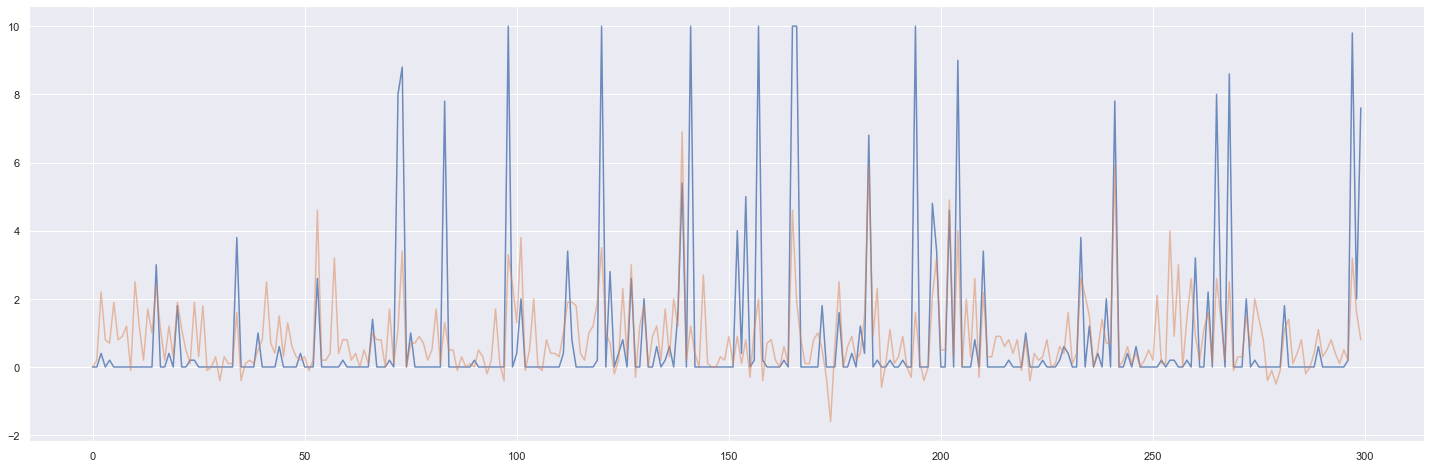

In [89]:
TRUNC = 300 #-1: do not trunc
x = np.linspace(0,y_test_unscaled.shape[0]-1,y_test_unscaled.shape[0])
plt.figure(figsize=(25,8))
plt.plot(x[0:TRUNC],y_test_unscaled[0:TRUNC],alpha=.8)
plt.plot(x[0:TRUNC],y_pred_unscaled[0:TRUNC],alpha=.5)